<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/VGG_CNN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

def get_data():
  data_set=torch.load('/content/gdrive/My Drive/Colab Notebooks/APS360 GROUP/1k-images.pt')
  return  data_set

Data Loading and Splitting

In [48]:
# Prepare Dataloader
def get_data_loader( classes , batchsize, dataset):

  indices = np.arange(len(dataset))

# Split into train and validation  test
  np.random.seed(20) # Fixed numpy random seed for reproducible shuffling
  np.random.shuffle(indices)
  split = int(len(indices) * 0.6) #split at 60%
  split2=int(len(indices)*0.8)

#  # split into training and validationand test indices
  relevant_train_indices, relevant_val_indices  ,relevant_test_indices = indices[:split], indices[split:split2] , indices[split2:]
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,num_workers=1, sampler=train_sampler)
                                      
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                              num_workers=1, sampler=val_sampler)
  # # Get the list of indices to sample from
  
  test_sampler = SubsetRandomSampler(relevant_test_indices)
  test_loader = torch.utils.data.DataLoader(dataset, batch_size=batchsize,
                                          num_workers=1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

In [9]:
# # Verification Step - obtain one batch of images
def verify(data_loader,classes):

  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()
  images, labels=dataiter.next()

  images = images.numpy()
  
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(images[idx])
      ax.set_title(classes[labels[idx]])

In [49]:
def save_vgg_features(data_loader,loader_name,feature_path, classes):
  n = 0
  for img, label in data_loader:
    img=img.permute(0,3,1,2)
    features = vgg.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
    folder_name = feature_path + '/' +loader_name+'/'+ str(classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), folder_name + '/' + str(n) + '.tensor')
    n += 1
  print(loader_name,"features saved")

In [52]:
# Prepare Dataset
dataset= get_data()


In [7]:
# Prepare DataLoader
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=32, dataset=dataset)

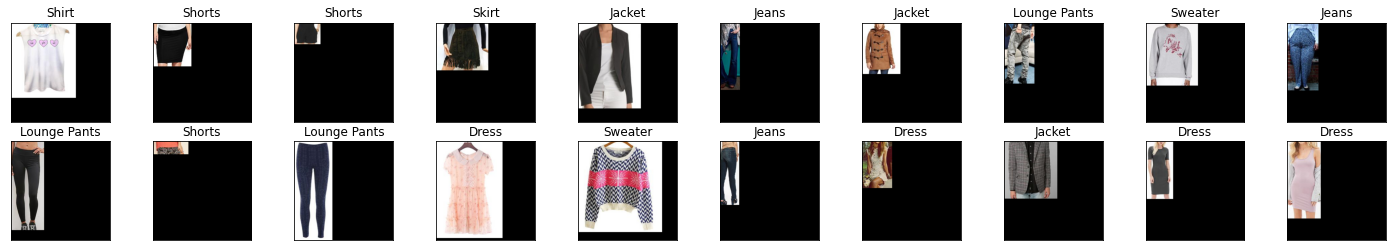

In [10]:
verify(train_loader,classes)


**Only Run the following if you don't have the features of vgg**

In [53]:
import torchvision.models
import os
vgg = torchvision.models.vgg19(pretrained=True)
# initialize path
feature_path = '/content/gdrive/My Drive/Colab Notebooks/1k_vgg_features'

# Prepare Dataloader 
#dataset= get_data()
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']
train_loader, val_loader, test_loader=get_data_loader(classes=classes, batchsize=1, dataset=dataset)

save_vgg_features(train_loader,"train",feature_path, classes=classes)
save_vgg_features(val_loader,"val",feature_path, classes=classes)
save_vgg_features(test_loader,"test",feature_path, classes=classes)


train features saved
val features saved
test features saved


In [46]:
#free up some memory
del dataset

In [3]:
def get_alex_data_loader(batch_size):
  train_dir = '/content/gdrive/My Drive/Colab Notebooks/24k_vgg_features/train'
  test_dir = '/content/gdrive/My Drive/Colab Notebooks/24k_vgg_features/test'
  val_dir = '/content/gdrive/My Drive/Colab Notebooks/24k_vgg_features/val'
  train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
  val_set= torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))
  torch.manual_seed(1) # set the random seed



  num_workers = 1
  train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)


  return train_feature_loader, test_feature_loader,val_feature_loader

In [18]:
#Prepare feature loader
train_feature_loader, test_feature_loader,val_feature_loader=get_alex_data_loader(128)

In [19]:
# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([128, 512, 9, 9])
torch.Size([128])


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_ALEX(nn.Module):
    def __init__(self):
        super(CNN_ALEX, self).__init__()
        self.name="CNN_ALEX"
        #self.conv = nn.Conv2d(256, 10, 3)
        # self.pool = nn.MaxPool2d(2, 2)
        # self.conv1 = nn.Conv2d(256, 10, 3)
        # self.pool1 = nn.MaxPool2d(2, 2)

        #self.fc1 = nn.Linear( 256* 8* 8, 32)
        # self.fc2 = nn.Linear(32, 8)
        #self.conv = nn.Conv2d(512, 500, 5)
        # self.conv2= nn.Conv2d(150, 100, 5,padding=2)
        # self.conv3= nn.Conv2d(100, 100, 5,padding=2)

       # self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*9*9, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        #x = self.pool(F.relu(self.conv(x)))
        # #print("shape1",x.shape)
        # x = self.pool(F.relu(self.conv2(x)))
        # #print("shape2",x.shape)

        # x = self.pool(F.relu(self.conv3(x)))
        # print("shape3",x.shape)


        x = x.view(x.shape[0], 512*9*9) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

In [21]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [22]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [32]:
def train_net(model,target_classes,train_loader,val_loader, batch_size=64, learn_rate=0.001, num_epochs=30):
    ########################################################################
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy,which will apply softmax to the output layer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time=time.time()
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_loss[epoch] = float(total_train_loss) / (batch_size)
        train_acc[epoch]= get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    end_time= time.time()

    # Write the train/test loss/err into CSV file 
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time: " , (end_time-start_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

TO DO: Hyper parameter tuning

Epoch 1: Train acc: 0.8200849992129703, Train loss: 0.6501200664788485 |Validation acc: 0.7144549763033176
Epoch 2: Train acc: 0.9054777270580828, Train loss: 0.3527997392229736 |Validation acc: 0.7481042654028436
Epoch 3: Train acc: 0.9456949472690067, Train loss: 0.23427925258874893 |Validation acc: 0.745260663507109
Epoch 4: Train acc: 0.946954194868566, Train loss: 0.1509285156498663 |Validation acc: 0.7232227488151659
Epoch 5: Train acc: 0.9841019990555643, Train loss: 0.1037895922199823 |Validation acc: 0.747867298578199
Epoch 6: Train acc: 0.9956713363765151, Train loss: 0.062105571560095996 |Validation acc: 0.7502369668246446
Epoch 7: Train acc: 0.9977176137257988, Train loss: 0.03602737563778646 |Validation acc: 0.745260663507109
Epoch 8: Train acc: 0.9977963167007713, Train loss: 0.022687013261020184 |Validation acc: 0.747867298578199
Epoch 9: Train acc: 0.996537069101212, Train loss: 0.014464198793575633 |Validation acc: 0.74739336492891
Epoch 10: Train acc: 0.99992129702502

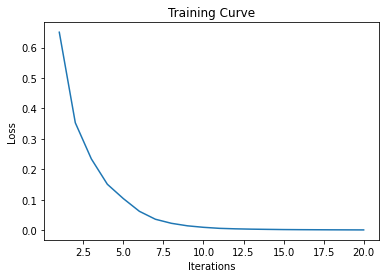

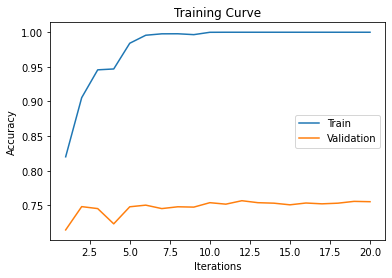

In [58]:
use_cuda = True
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']

model=CNN_ALEX()
#Modify
if use_cuda and torch.cuda.is_available():
    model.cuda()
train_net(model, classes,train_feature_loader, val_feature_loader, batch_size=128, num_epochs=20, learn_rate = 0.001)

In [12]:
torch.save(model.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/CNN_VGG_24k_combined")

In [13]:
model.load_state_dict(torch.load("/content/gdrive/My Drive/Colab Notebooks/CNN_VGG_24k_combined"))

<All keys matched successfully>

In [14]:
get_accuracy(model,test_feature_loader)

0.7537050105857446

In [ ]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[477.,  20.,   1.,   1.,   5.,   1.,  22.,   7.],
        [ 12., 424.,   2.,   6.,  20.,   5.,  11.,  43.],
        [  2.,   2., 443.,  74.,   1.,  12.,  10.,   1.],
        [  3.,   1.,  67., 416.,   1.,  26.,  17.,   3.],
        [ 16.,  24.,   1.,   2., 384.,  10.,  16.,  91.],
        [  0.,   3.,  15.,  24.,   4., 454.,  70.,   2.],
        [  3.,   2.,   7.,  13.,   4.,  64., 400.,   4.],
        [ 11.,  39.,   3.,   1.,  40.,  12.,   8., 404.]])
tensor([0.8933, 0.8107, 0.8128, 0.7790, 0.7059, 0.7937, 0.8048, 0.7799])


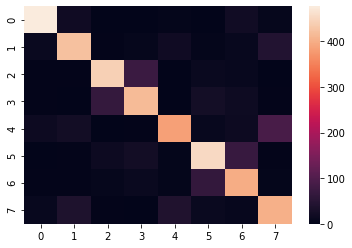

In [ ]:
get_confusion_matrix(model,test_feature_loader)